## Classification- InceptionV3 with 22 Categories
- Model's Category Classification for any image 
    - Provides probability for each clssification category
    - Check y_true & y_pred_top_class for a all files in a class
    - Check criteria for y_true not matching y_Pred by Category Names
    - Look up details of an example by index number -- all these outputs can be fed into an app
    - For any Image, feed in Index No. and get Top3 Predicted Categories and Probailites Respectively
    - Plotting an Image given Index no. in Model_PredictionDF
    
 
  


In [1]:
! pip install theano

In [1]:
import pandas as pd

In [2]:
#KERAS
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
#from keras.optimizers import SGD,RMSprop,adam
from keras.utils import np_utils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
#import theano
from PIL import Image
from numpy import *
# SKLEARN
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import keras.backend as K

In [4]:
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 40)
pd.set_option('display.precision', 3)

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
import ipywidgets as widgets # Loads the Widget framework.
from IPython.core.magics.namespace import NamespaceMagics # Used to query namespace.

# For this example, hide these names, just to avoid polluting the namespace further
get_ipython().user_ns_hidden['widgets'] = widgets
get_ipython().user_ns_hidden['NamespaceMagics'] = NamespaceMagics

In [7]:
class VariableInspectorWindow(object):
    instance = None

    def __init__(self, ipython):
        """Public constructor."""
        if VariableInspectorWindow.instance is not None:
            raise Exception("""Only one instance of the Variable Inspector can exist at a
                time.  Call close() on the active instance before creating a new instance.
                If you have lost the handle to the active instance, you can re-obtain it
                via `VariableInspectorWindow.instance`.""")

        VariableInspectorWindow.instance = self
        self.closed = False
        self.namespace = NamespaceMagics()
        self.namespace.shell = ipython.kernel.shell

        self._box = widgets.Box()
        self._box.layout.overflow_y = 'scroll'
        self._table = widgets.HTML(value = 'Not hooked')
        self._box.children = [self._table]

        self._ipython = ipython
        self._ipython.events.register('post_run_cell', self._fill)

    def close(self):
        """Close and remove hooks."""
        if not self.closed:
            self._ipython.events.unregister('post_run_cell', self._fill)
            self._box.close()
            self.closed = True
            VariableInspectorWindow.instance = None

    def _fill(self):
        """Fill self with variable information."""
        values = self.namespace.who_ls()
        self._table.value = '<div class="rendered_html jp-RenderedHTMLCommon"><table><thead><tr><th>Name</th><th>Type</th><th>Value</th></tr></thead><tr><td>' + \
            '</td></tr><tr><td>'.join(['{0}</td><td>{1}</td><td>{2}'.format(v, type(eval(v)).__name__, str(eval(v))) for v in values]) + \
            '</td></tr></table></div>'

    def _ipython_display_(self):
        """Called when display() or pyout is used to display the Variable
        Inspector."""
        self._box._ipython_display_()

In [8]:
inspector = VariableInspectorWindow(get_ipython())
inspector

Box(children=(HTML(value='Not hooked'),), layout=Layout(overflow_y='scroll'))

In [9]:
import pickle 

In [10]:
from PIL import Image, ImageChops

## ----> Start running NB from here

#### Load DFs big_data, train and val

In [11]:
with open('/home/ubuntu/data/Categories_22/big_data.pkl', 'rb') as picklefile_big_data: 
    big_data = pickle.load(picklefile_big_data)

In [12]:
with open('/home/ubuntu/data/Categories_22/train.pkl', 'rb') as picklefile_train:
    train = pickle.load(picklefile_train)

In [13]:
with open('/home/ubuntu/data/Categories_22/val.pkl', 'rb') as picklefile_val:
    val = pickle.load(picklefile_val)

## Model 1 
### InceptionV3

In [11]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

In [12]:
import keras
import keras.backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
#import vis

#### Metrics & Plotting

In [13]:
# Metrics for accuracy - sparse top 3 categorical
#Checks whether y_true matches any of the top3 predictions(Y_preds)/classes with top3 probabilites predicted by model 
#Use Y_pred with probabilitites for each class and not y_pred that gives only a single predicted class corresponding
#to class with highest probability

def top_3(y_true, Y_pred):  
    return keras.metrics.top_k_categorical_accuracy(y_true, Y_pred, k=3)

In [14]:
def plot_confusion(title_plot,y_test, y_pred):
    
    c_mat = confusion_matrix(y_test,y_pred)
    labels = sorted(label_dict.items(),key = lambda x: x[1])# or use---> unique(y_test)
    sns.heatmap(
        sqrt(c_mat),
        annot=np.true_divide(c_mat, c_mat.sum(axis=1, keepdims=True))*100, #annotations on Plot are in % for each row
        cmap= plt.cm.Reds,
        xticklabels=labels,
        yticklabels=labels,
        cbar=True);
    ylabel("True Label", fontsize = 'large',fontweight ='bold' )
    xlabel("Predicted Label", fontsize = 'large',fontweight ='bold' )
    title(title_plot, fontsize = 'xx-large',fontweight ='bold' )

In [15]:
# plots the model's score metrics: loss and accuracy and top k accuracy

def plot_history(history): 
    measures = np.unique([m.replace('val_', '') for m in history.history.keys()])
    num_meas = len(measures)
    x = arange(len(history.history[measures[0]]))
    fix, axes = subplots(nrows=num_meas,ncols=1,squeeze=True, sharex=True,figsize=(6,2*num_meas), tight_layout=True)
    if num_meas == 1:
        axes = [axes]
    for i,meas in enumerate(measures):
        axes[i].plot(x, history.history[meas], label=meas)
        if "val_"+meas in history.history.keys():
            axes[i].plot(x, history.history["val_"+meas], label="val_"+meas)
        axes[i].legend()
        if meas in ["acc", "top_3"]:
            axes[i].set_ylim((-0.01,1.01))
    axes[-1].set_xlabel("epoch");

### Image Generator Pre-processing

In [16]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True,
    zca_epsilon=1e-6,
    horizontal_flip=True,
    rotation_range=15,  
    width_shift_range=4/200,
    height_shift_range=4/200,
    fill_mode='constant',
    cval=0.,
    data_format=K.image_data_format()
    )

test_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    zca_whitening=True,
    zca_epsilon=1e-6)

In [17]:
train_generator = train_datagen.flow_from_directory(
        '/home/ubuntu/data/Categories_22/Model_Train_Val_set/Train_Set',
        target_size=(200, 200), #image width & height
        batch_size=32,
        class_mode='categorical',
        classes=['Cat00', 'Cat01','Cat02','Cat03', 'Cat04', 'Cat05','Cat06', 'Cat07', 'Cat08','Cat09', 'Cat10',\
                 'Cat11','Cat12', 'Cat13','Cat14','Cat15', 'Cat16', 'Cat17','Cat18', 'Cat19', 'Cat20','Cat21'])

Found 16517 images belonging to 22 classes.


In [22]:
train.Process_Files.nunique()

16517

In [40]:
len(val)

4400

In [41]:
val.Process_Files.nunique()

4307


**Note** No. of images are less than the length test and train df as some of the classes with less than 1000 exmaples
were usampled with the same image


In [28]:
validation_generator = test_datagen.flow_from_directory(
        '/home/ubuntu/data/Categories_22/Model_Train_Val_set/Test_Set',
        target_size=(200, 200),
        batch_size=32,
        class_mode='categorical',
        shuffle= False,
        classes=['Cat00', 'Cat01','Cat02','Cat03', 'Cat04', 'Cat05','Cat06', 'Cat07', 'Cat08','Cat09', 'Cat10',\
                 'Cat11','Cat12', 'Cat13','Cat14','Cat15', 'Cat16', 'Cat17','Cat18', 'Cat19', 'Cat20','Cat21'])

Found 4307 images belonging to 22 classes.


### Model Architecture

In [52]:
# create the base pre-trained model
base_model_big = InceptionV3(weights='imagenet', include_top=False)

In [53]:
# add a global spatial average pooling layer
x = base_model_big.output
x = GlobalAveragePooling2D()(x)

In [54]:
#Classification Layers
# let's add a fully-connected layer
x = Dropout(.35)(x)
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- 22 classes
x = Dropout(.25)(x)
predictions = Dense(22, activation='softmax')(x)

In [55]:
# this is the model we will train
model_big = Model(inputs=base_model_big.input, outputs=predictions)

In [56]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model_big.layers:
    layer.trainable = False

In [57]:
'''
# compile the model (should be done *after* setting layers to non-trainable)
model_big.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy', top_3])

'''

In [58]:
model_big.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv2d_189 (Conv2D)              (None, None, None, 32 864         input_3[0][0]                    
____________________________________________________________________________________________________
batch_normalization_189 (BatchNo (None, None, None, 32 96          conv2d_189[0][0]                 
____________________________________________________________________________________________________
activation_189 (Activation)      (None, None, None, 32 0           batch_normalization_189[0][0]    
___________________________________________________________________________________________

## Train Top Layers i.e. Classification Layers

Note: Freeze all the base model layers i.e. the 9 InceptionV3 modules. Train only Classificaition Layer

Epoch 1/100


/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:506: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:514: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:524: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.


550/550 [==============================] - 156s - loss: 2.8701 - acc: 0.1530 - top_3: 0.3548 - val_loss: 2.5354 - val_acc: 0.2219 - val_top_3: 0.4606
Epoch 2/100
550/550 [==============================] - 154s - loss: 2.5891 - acc: 0.2155 - top_3: 0.4477 - val_loss: 2.4362 - val_acc: 0.2446 - val_top_3: 0.4988
Epoch 3/100
550/550 [==============================] - 152s - loss: 2.5364 - acc: 0.2310 - top_3: 0.4702 - val_loss: 2.4795 - val_acc: 0.2501 - val_top_3: 0.4985
Epoch 4/100
550/550 [==============================] - 153s - loss: 2.5137 - acc: 0.2407 - top_3: 0.4832 - val_loss: 2.4032 - val_acc: 0.2650 - val_top_3: 0.5183
Epoch 5/100
550/550 [==============================] - 154s - loss: 2.4876 - acc: 0.2441 - top_3: 0.4874 - val_loss: 2.3862 - val_acc: 0.2687 - val_top_3: 0.5208
Epoch 6/100
550/550 [==============================] - 153s - loss: 2.4902 - acc: 0.2459 - top_3: 0.4851 - val_loss: 2.4132 - val_acc: 0.2625 - val_top_3: 0.5081
Epoch 7/100
549/550 [===================

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


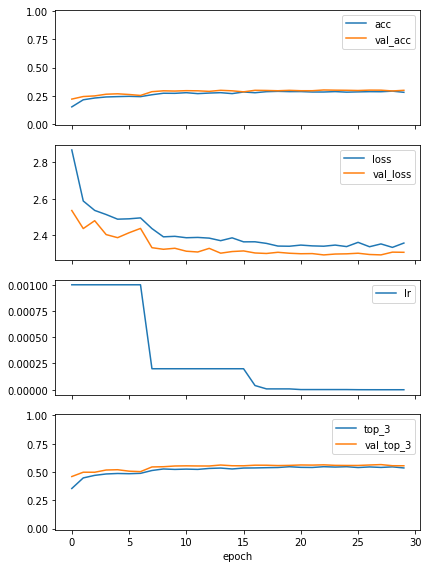

In [59]:
'''
%%time


hist = model_big.fit_generator(
        train_generator,
        steps_per_epoch=17600/32,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=4400/ 32,
        callbacks=[keras.callbacks.EarlyStopping(patience=6,verbose=1),
        keras.callbacks.ReduceLROnPlateau(factor=.2, patience=1, verbose=1)])


plot_history(hist)

'''

In [60]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model_big.layers):
    print(i, layer.name)

0 input_3
1 conv2d_189
2 batch_normalization_189
3 activation_189
4 conv2d_190
5 batch_normalization_190
6 activation_190
7 conv2d_191
8 batch_normalization_191
9 activation_191
10 max_pooling2d_9
11 conv2d_192
12 batch_normalization_192
13 activation_192
14 conv2d_193
15 batch_normalization_193
16 activation_193
17 max_pooling2d_10
18 conv2d_197
19 batch_normalization_197
20 activation_197
21 conv2d_195
22 conv2d_198
23 batch_normalization_195
24 batch_normalization_198
25 activation_195
26 activation_198
27 average_pooling2d_19
28 conv2d_194
29 conv2d_196
30 conv2d_199
31 conv2d_200
32 batch_normalization_194
33 batch_normalization_196
34 batch_normalization_199
35 batch_normalization_200
36 activation_194
37 activation_196
38 activation_199
39 activation_200
40 mixed0
41 conv2d_204
42 batch_normalization_204
43 activation_204
44 conv2d_202
45 conv2d_205
46 batch_normalization_202
47 batch_normalization_205
48 activation_202
49 activation_205
50 average_pooling2d_20
51 conv2d_201
52 

In [61]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model_big.layers[:249]:
    layer.trainable = False
for layer in model_big.layers[249:]:
    layer.trainable = True

In [62]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model_big.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy', top_3])

Epoch 1/100


/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:506: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:514: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:524: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.


550/550 [==============================] - 163s - loss: 2.3056 - acc: 0.2958 - top_3: 0.5537 - val_loss: 2.2331 - val_acc: 0.3159 - val_top_3: 0.5878
Epoch 2/100
550/550 [==============================] - 160s - loss: 2.2665 - acc: 0.3020 - top_3: 0.5671 - val_loss: 2.1809 - val_acc: 0.3307 - val_top_3: 0.6019
Epoch 3/100
550/550 [==============================] - 160s - loss: 2.2135 - acc: 0.3182 - top_3: 0.5884 - val_loss: 2.1417 - val_acc: 0.3373 - val_top_3: 0.6148
Epoch 4/100
550/550 [==============================] - 160s - loss: 2.1806 - acc: 0.3315 - top_3: 0.5955 - val_loss: 2.1166 - val_acc: 0.3457 - val_top_3: 0.6209
Epoch 5/100
550/550 [==============================] - 160s - loss: 2.1478 - acc: 0.3355 - top_3: 0.6024 - val_loss: 2.0850 - val_acc: 0.3504 - val_top_3: 0.6337
Epoch 6/100
550/550 [==============================] - 160s - loss: 2.1163 - acc: 0.3464 - top_3: 0.6159 - val_loss: 2.0632 - val_acc: 0.3548 - val_top_3: 0.6364
Epoch 7/100
550/550 [===================

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


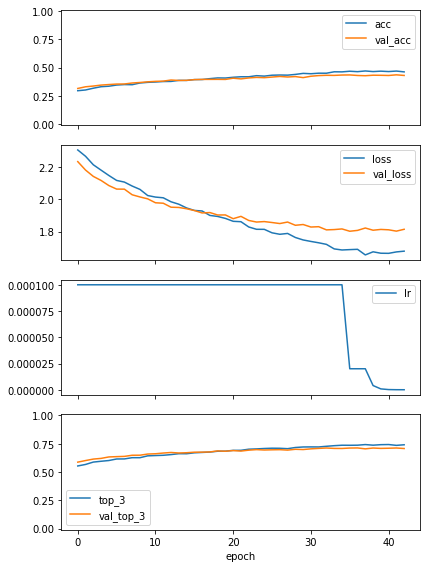

In [63]:
'''
%%time
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
hist2 = model_big.fit_generator(train_generator,
        steps_per_epoch=17600/32,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=4400/ 32,
        callbacks=[keras.callbacks.EarlyStopping(patience=6,verbose=1),
        keras.callbacks.ReduceLROnPlateau(factor=.2, patience=1, verbose=1)]) 


plot_history(hist2)
'''

### Save Model

In [18]:
from keras.models import load_model

In [65]:
'''
model_big.save('/home/ubuntu/data/Categories_22/modelInception_Big22.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model
'''

In [19]:
# returns a compiled model
# identical to the previous one
model_big = load_model('/home/ubuntu/data/Categories_22/modelInception_Big22.h5',\
                    custom_objects={'top_3': top_3})

## --->  Predicted Y  label 
### --->   Run the section  for fresh predictions

#### Model Predicted probabilities for the 10 classes  and Highest Predicted Class for each example

**Important Note:**  Make validation_generator's shuffle argument False but keep the train_generator Shuffle as false

In [26]:
%%time

predictions_class_prob= model_big.predict_generator(validation_generator, max_queue_size=1,steps=4307/32)


/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:506: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:514: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
/usr/local/lib/python3.5/dist-packages/Keras-2.0.8-py3.5.egg/keras/preprocessing/image.py:524: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.


CPU times: user 34.1 s, sys: 1.7 s, total: 35.8 s
Wall time: 29.2 s


In [60]:
'''
with open('/home/ubuntu/data/Categories_22/predictions_22.pkl', 'wb') as picklefile_predictions_22:
    pickle.dump( predictions_class_prob, picklefile_predictions_22, protocol=4)
'''

In [23]:

with open('/home/ubuntu/data/Categories_22/predictions_22.pkl', 'rb') as picklefile_predictions_22:
    predictions_class_prob = pickle.load(picklefile_predictions_22)

    

In [ ]:
print('Probabilities for each class:\n')
predictions_class_prob

In [24]:
# Class with highest predicted probability for each example
y_pred = np.argmax(predictions_class_prob, axis=1)

In [25]:
print('Predicted Labels:\n')
y_pred

Predicted Labels:



array([ 9, 19,  5, ...,  2, 21, 21])

### -----> Issue finding True y label

validation_generator.classes does print the True labels but in the order that they are retrieved from the directory, it doesn't take into account the batching or sample expansion by augmentation.
https://q-a-assistant.info/computer-internet-technology/keras-get-true-labels-y-test-from-imagedatagenerator-or-predict-generator/1165857

In [26]:
y_true = validation_generator.classes  # True Lable

In [30]:
y_true 

array([ 0,  0,  0, ..., 21, 21, 21], dtype=int32)

In [113]:
'''
with open('/home/ubuntu/data/Categories_22/ytrue_22.pkl', 'wb') as picklefile_ytrue_22:
    pickle.dump( y_true , picklefile_ytrue_22, protocol=4)
'''

"\nwith open('/home/ubuntu/data/Categories_22/ytrue_22.pkl', 'wb') as picklefile_ytrue_22:\n    pickle.dump( y_true , picklefile_ytrue_22, protocol=4)\n"

In [114]:
with open('/home/ubuntu/data/Categories_22/ytrue_22.pkl', 'rb') as picklefile_ytrue_22:
    y_true = pickle.load(picklefile_ytrue_22)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/data/Categories_22/ytrue_22.pkl'

In [31]:
validation_generator.filenames

['Cat00/Tartan_Plaid_Chiffon_Blouse+img_00000069.jpg',
 'Cat00/Floral_Print_Peasant_Blouse+img_00000113.jpg',
 'Cat00/Dotted_Crepe_Blouse+img_00000022.jpg',
 'Cat00/Mandarin_Collar_Blouse+img_00000130.jpg',
 'Cat00/Collarless_V-Neck_Blouse+img_00000099.jpg',
 'Cat00/Crochet-Paneled_Collared_Blouse+img_00000055.jpg',
 'Cat00/Layered-Panel_Chiffon_Blouse+img_00000011.jpg',
 'Cat00/Tasseled_Neckline_Stripe_Blouse+img_00000099.jpg',
 'Cat00/Keyhole_Abstract_Print_Blouse+img_00000026.jpg',
 'Cat00/Boxy_Angel-Sleeved_Blouse+img_00000027.jpg',
 'Cat00/Butterfly_Print_Blouse+img_00000057.jpg',
 'Cat00/Baroque_Print_Blouse+img_00000118.jpg',
 'Cat00/Pintucked_Eyelash_Lace_Blouse+img_00000001.jpg',
 'Cat00/Chambray_Popover_Blouse+img_00000081.jpg',
 'Cat00/Sleeveless_Classic_Woven_Blouse+img_00000087.jpg',
 'Cat00/Checkered_Print_Chiffon_Blouse+img_00000060.jpg',
 'Cat00/Rhinestoned_&_Beaded_Blouse+img_00000048.jpg',
 'Cat00/Dotted_Lace-Paneled_Blouse+img_00000041.jpg',
 'Cat00/Floral_Lace_Blous

In [62]:
len(validation_generator.filenames)

4307

In [63]:
validation_generator.filenames[4300]

'Cat21/Speckled_Raw_Edge_Tee+img_00000012.jpg'

In [32]:
# Labels as per model...in the order that it is reading from the folders
validation_generator.class_indices

{'Cat00': 0,
 'Cat01': 1,
 'Cat02': 2,
 'Cat03': 3,
 'Cat04': 4,
 'Cat05': 5,
 'Cat06': 6,
 'Cat07': 7,
 'Cat08': 8,
 'Cat09': 9,
 'Cat10': 10,
 'Cat11': 11,
 'Cat12': 12,
 'Cat13': 13,
 'Cat14': 14,
 'Cat15': 15,
 'Cat16': 16,
 'Cat17': 17,
 'Cat18': 18,
 'Cat19': 19,
 'Cat20': 20,
 'Cat21': 21}

In [33]:
# Labels as per model...in the order that it is reading from the folders
val_label_dic =validation_generator.class_indices

In [34]:

# Labels as per dataframe
label_dict  = dict(zip(val.category_name,val.label_i))
label_dict

{'Blazer': 1,
 'Blouse': 0,
 'Cardigan': 5,
 'Coat': 18,
 'Culottes': 15,
 'Cutoffs': 13,
 'Dress': 16,
 'Hoodie': 4,
 'Jacket': 6,
 'Jeans': 11,
 'Joggers': 12,
 'Jumpsuit': 20,
 'Kimono': 19,
 'Leggings': 14,
 'Parka': 8,
 'Poncho': 7,
 'Romper': 17,
 'Shorts': 10,
 'Skirt': 9,
 'Sweater': 3,
 'Tank': 2,
 'Tee': 21}

In [27]:
import seaborn as sns

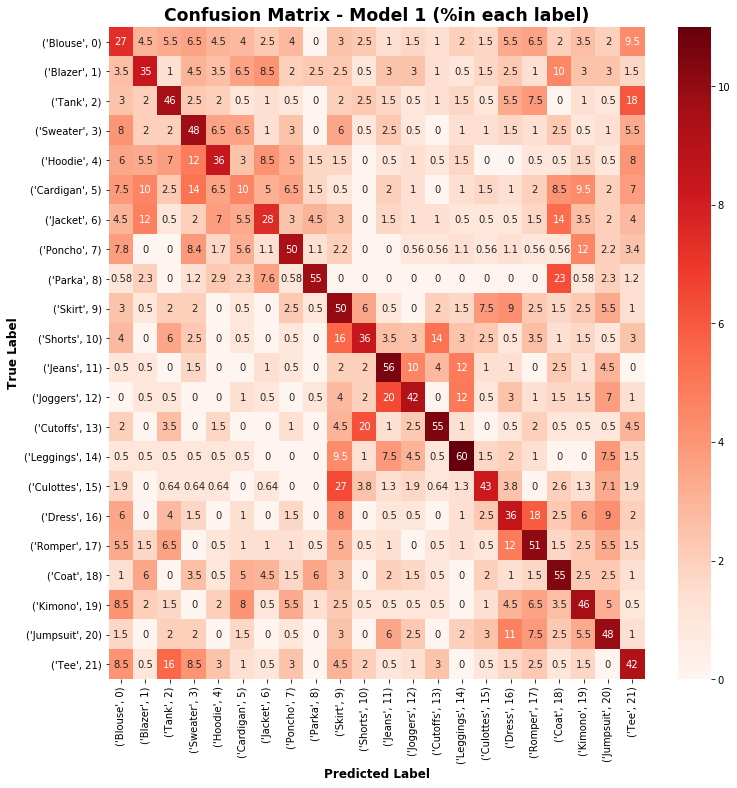

In [36]:
#### Confusion Matrix

from sklearn.metrics import classification_report,confusion_matrix

figsize(12, 12)
plot_confusion('Confusion Matrix - Model 1 (%in each label)',y_true,y_pred)# Adding 1 to y_pred as our labels/catgories start from1

In [37]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy: %.3f"% accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

Accuracy: 0.433
             precision    recall  f1-score   support

          0       0.25      0.27      0.26       200
          1       0.41      0.35      0.38       200
          2       0.43      0.46      0.44       200
          3       0.40      0.47      0.43       200
          4       0.46      0.35      0.40       200
          5       0.17      0.10      0.13       200
          6       0.40      0.28      0.33       200
          7       0.51      0.50      0.51       179
          8       0.71      0.55      0.62       172
          9       0.32      0.49      0.39       200
         10       0.46      0.35      0.40       200
         11       0.50      0.56      0.52       200
         12       0.53      0.42      0.47       200
         13       0.65      0.55      0.59       200
         14       0.58      0.60      0.59       200
         15       0.53      0.43      0.48       156
         16       0.35      0.36      0.36       200
         17       0.44      0

### Make a dataframe of Model Predictions for all test cases

In [91]:
y_pred_prob = predictions_class_prob 


In [100]:
list_y_pred_prob =list(y_pred_prob)


In [103]:
list_y_pred_prob

[array([ 0.21958494,  0.01966109,  0.01254045,  0.15918767,  0.00836517,
         0.08635763,  0.01846996,  0.05883942,  0.00107883,  0.26254046,
         0.0258944 ,  0.00049318,  0.00175188,  0.0019411 ,  0.00157442,
         0.00844056,  0.03506266,  0.00816816,  0.0169686 ,  0.02994961,
         0.00330968,  0.01982019], dtype=float32),
 array([  1.35272115e-01,   2.90794633e-02,   4.10585515e-02,
          2.78041083e-02,   1.52743176e-01,   2.71308534e-02,
          2.88192853e-02,   1.37522697e-01,   6.94072660e-05,
          1.13674731e-03,   6.89244596e-04,   8.23056052e-06,
          4.64556651e-05,   8.42983543e-04,   4.61116433e-05,
          4.86436011e-06,   3.17409495e-03,   7.32400641e-03,
          1.77497466e-04,   2.05964416e-01,   1.83413926e-04,
          2.00902209e-01], dtype=float32),
 array([  6.01264164e-02,   8.69426280e-02,   8.67479946e-04,
          3.27239484e-02,   1.93540473e-02,   3.57925475e-01,
          1.51910871e-01,   3.29912715e-02,   2.07772907

In [189]:
TopClass_1 = []
TopClass_2 = []
TopClass_3 = []
Prob_Class_1 = []
Prob_Class_2 = []
Prob_Class_3 = []

In [194]:
# Checking how np array sort works
a = np.array([1, 3, 2, 4, 5])

index = a.argsort()[-3:][::-1]

print('Sorted Indicies:',index,'\nSorted Values:',a[index])

Sorted Indicies: [4 3 1] 
Sorted Values: [5 4 3]


In [195]:
%%time
for a in list_y_pred_prob:
    #print(a)
    index = a.argsort()[-3:][::-1]
    TopClass_1.append(index[0])
    TopClass_2.append(index[1])
    TopClass_3.append(index[2])
    #print(index)
    #print(a[index])
    #print(TopClass_1,TopClass_2,TopClass_3)
    Prob_Class_1.append(a[index][0])
    Prob_Class_2.append(a[index][1])
    Prob_Class_3.append(a[index][2])
    #print(Prob_Class_1,Prob_Class_2,Prob_Class_3)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 16.8 ms


 ####  Formating Prob_Class_1,Prob_Class_2,Prob_Class_3  to 2 decimal place and % format

In [196]:
%%time
for i in range(len(Prob_Class_1)):  
    Prob_Class_1[i] = "%.2f" %(Prob_Class_1[i]*100)
    Prob_Class_2[i] = "%.2f" %(Prob_Class_2[i]*100)
    Prob_Class_3[i] = "%.2f" %(Prob_Class_3[i]*100)
   

CPU times: user 48 ms, sys: 0 ns, total: 48 ms
Wall time: 46.1 ms


### Switching key and value of dictionary label_dict

In [197]:
label_dict

{'Blazer': 1,
 'Blouse': 0,
 'Cardigan': 5,
 'Coat': 18,
 'Culottes': 15,
 'Cutoffs': 13,
 'Dress': 16,
 'Hoodie': 4,
 'Jacket': 6,
 'Jeans': 11,
 'Joggers': 12,
 'Jumpsuit': 20,
 'Kimono': 19,
 'Leggings': 14,
 'Parka': 8,
 'Poncho': 7,
 'Romper': 17,
 'Shorts': 10,
 'Skirt': 9,
 'Sweater': 3,
 'Tank': 2,
 'Tee': 21}

In [85]:
Dict_id_cat = {y:x for x,y in label_dict.items()}

In [86]:
Dict_id_cat

{0: 'Blouse',
 1: 'Blazer',
 2: 'Tank',
 3: 'Sweater',
 4: 'Hoodie',
 5: 'Cardigan',
 6: 'Jacket',
 7: 'Poncho',
 8: 'Parka',
 9: 'Skirt',
 10: 'Shorts',
 11: 'Jeans',
 12: 'Joggers',
 13: 'Cutoffs',
 14: 'Leggings',
 15: 'Culottes',
 16: 'Dress',
 17: 'Romper',
 18: 'Coat',
 19: 'Kimono',
 20: 'Jumpsuit',
 21: 'Tee'}

In [203]:
Name_TopClass_1 = []
Name_TopClass_2 = []
Name_TopClass_3 = []
y_True_Name =[]

### Converting Label id to Label name for Top 3 classes & y_true

In [204]:
%%time
for i in range(len(TopClass_1)):
    Name_TopClass_1.append(Dict_id_cat[TopClass_1[i]]) 
    Name_TopClass_2.append(Dict_id_cat[TopClass_2[i]]) 
    Name_TopClass_3.append(Dict_id_cat[TopClass_3[i]]) 
    y_True_Name.append(Dict_id_cat[y_true[i]])

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 14.1 ms


In [92]:
y_pred_top_class = np.argmax(predictions_class_prob, axis=1)

In [93]:
y_true = validation_generator.classes 

In [94]:
x_filenames = validation_generator.filenames

In [207]:
'''
%%time
data = [('y_trueN', y_True_Name), # y True Class Name
         ('y_true', y_true), # y True Label
         ('y_pred1', y_pred_top_class),# Class Number of Top Class
         ('Name1', Name_TopClass_1), # Names of Top Classes 1 to 3
         ('Name2', Name_TopClass_2),
         ('Name3', Name_TopClass_3),
         ('Class1', TopClass_1),  # Indicies Top Classes 1 to 3
         ('Class2', TopClass_2),
         ('Class3', TopClass_3),
         ('y_pred_prob', list_y_pred_prob),# list of probabilities of Classes 0 to 22 for the particular example
         ('x_files', x_filenames),  # Filenames of each example
         ('Prob_Class_1',Prob_Class_1),  # Probabilities of Top Classes 1 to 3
         ('Prob_Class_2',Prob_Class_2),
         ('Prob_Class_3',Prob_Class_3),
         ]
Model_PredictionDF = pd.DataFrame.from_items(data)
'''


CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 5.92 ms


In [208]:
Model_PredictionDF

,y_trueN,y_true,y_pred1,Name1,Name2,Name3,Class1,Class2,Class3,y_pred_prob,x_files,Prob_Class_1,Prob_Class_2,Prob_Class_3
0,Blouse,0,9,Skirt,Blouse,Sweater,9,0,3,"[0.219585, 0.0196611, 0.0125405, 0.159188, 0.0...",Cat00/Tartan_Plaid_Chiffon_Blouse+img_00000069...,26.25,21.96,15.92
1,Blouse,0,19,Kimono,Tee,Hoodie,19,21,4,"[0.135272, 0.0290795, 0.0410586, 0.0278041, 0....",Cat00/Floral_Print_Peasant_Blouse+img_00000113...,20.60,20.09,15.27
2,Blouse,0,5,Cardigan,Jacket,Kimono,5,6,19,"[0.0601264, 0.0869426, 0.00086748, 0.0327239, ...",Cat00/Dotted_Crepe_Blouse+img_00000022.jpg,35.79,15.19,12.52
3,Blouse,0,1,Blazer,Blouse,Jacket,1,0,6,"[0.25842, 0.568353, 0.000146036, 0.00301266, 0...",Cat00/Mandarin_Collar_Blouse+img_00000130.jpg,56.84,25.84,8.17
4,Blouse,0,1,Blazer,Jacket,Hoodie,1,6,4,"[0.101927, 0.272794, 0.0142341, 0.106649, 0.11...",Cat00/Collarless_V-Neck_Blouse+img_00000099.jpg,27.28,12.53,11.78
5,Blouse,0,16,Dress,Blouse,Tank,16,0,2,"[0.138882, 0.0147733, 0.133648, 0.0372687, 0.0...",Cat00/Crochet-Paneled_Collared_Blouse+img_0000...,18.87,13.89,13.36
6,Blouse,0,17,Romper,Tank,Dress,17,2,16,"[0.058872, 0.0322057, 0.130737, 0.0230195, 0.0...",Cat00/Layered-Panel_Chiffon_Blouse+img_0000001...,15.05,13.07,12.61
7,Blouse,0,17,Romper,Dress,Tank,17,16,2,"[0.110278, 0.00486785, 0.119801, 0.0103892, 0....",Cat00/Tasseled_Neckline_Stripe_Blouse+img_0000...,33.73,14.99,11.98
8,Blouse,0,0,Blouse,Poncho,Cardigan,0,7,5,"[0.348052, 0.0204297, 0.0113705, 0.0261323, 0....",Cat00/Keyhole_Abstract_Print_Blouse+img_000000...,34.81,22.35,10.47
9,Blouse,0,17,Romper,Dress,Jumpsuit,17,16,20,"[0.0648011, 0.0140688, 0.0264101, 0.00602266, ...",Cat00/Boxy_Angel-Sleeved_Blouse+img_00000027.jpg,40.55,25.37,13.25


In [209]:
'''
with open('/home/ubuntu/data/Categories_22/Model_PredictionDF.pkl', 'wb') as picklefile_Model_PredictionDF:
    pickle.dump( Model_PredictionDF , picklefile_Model_PredictionDF, protocol=4)
'''

In [20]:
with open('/home/ubuntu/data/Categories_22/Model_PredictionDF.pkl', 'rb') as picklefile_Model_PredictionDF:
    Model_PredictionDF = pickle.load(picklefile_Model_PredictionDF)

### Check y_true & y_pred_top_class for a all files in a class

In [33]:
Model_PredictionDF[(Model_PredictionDF['y_trueN']=='Coat')]

,y_trueN,y_true,y_pred1,Name1,Name2,Name3,Class1,Class2,Class3,y_pred_prob,x_files,Prob_Class_1,Prob_Class_2,Prob_Class_3
3507,Coat,18,18,Coat,Parka,Jacket,18,8,6,"[0.0277012, 0.0589496, 0.00156864, 0.00790811,...",Cat18/Classic_Double-Breasted_Trench_Coat+img_...,42.01,13.87,7.24
3508,Coat,18,18,Coat,Parka,Jacket,18,8,6,"[3.60638e-05, 0.00650865, 1.11568e-07, 0.00030...",Cat18/Faux_Fur_Collar_Coat+img_00000051.jpg,51.23,41.96,3.35
3509,Coat,18,1,Blazer,Jacket,Cardigan,1,6,5,"[0.0302895, 0.317986, 0.00860148, 0.0222298, 0...",Cat18/Collarless_Crepe_Trench_Coat+img_0000002...,31.80,21.86,13.13
3510,Coat,18,18,Coat,Blazer,Jacket,18,1,6,"[0.00985564, 0.253578, 3.34699e-05, 0.00130709...",Cat18/Drawstring_Waist_Trench_Coat+img_0000005...,40.70,25.36,19.98
3511,Coat,18,19,Kimono,Blouse,Romper,19,0,17,"[0.138389, 0.0684477, 0.0475683, 0.0214627, 0....",Cat18/Dolman_Sleeve_Trench_Coat+img_00000019.jpg,13.87,13.84,10.04
3512,Coat,18,5,Cardigan,Coat,Kimono,5,18,19,"[0.0155133, 0.0641943, 0.00207503, 0.0110038, ...",Cat18/Collarless_Crepe_Trench_Coat+img_0000002...,14.28,14.28,13.39
3513,Coat,18,18,Coat,Cardigan,Jacket,18,5,6,"[0.0728621, 0.0954279, 0.00589236, 0.0577814, ...",Cat18/Faux_Fur_Collar_Coat+img_00000042.jpg,22.37,11.30,11.14
3514,Coat,18,18,Coat,Jacket,Blazer,18,6,1,"[0.0152514, 0.0988939, 0.00202476, 0.0158477, ...",Cat18/Open-Front_Duster_Coat+img_00000043.jpg,20.91,14.60,9.89
3515,Coat,18,5,Cardigan,Coat,Jumpsuit,5,18,20,"[0.0198903, 0.0685829, 0.00118418, 0.0210783, ...",Cat18/Collarless_Scuba_Knit_Coat+img_00000017.jpg,18.19,16.62,11.04
3516,Coat,18,1,Blazer,Coat,Jacket,1,18,6,"[0.000118283, 0.489459, 3.12699e-08, 0.0001338...",Cat18/Boxy_Double-Breasted_Coat+img_00000050.jpg,48.95,25.97,16.03


## Check for y_true not matching y_Pred by Category Names

In [348]:
Model_PredictionDF[(Model_PredictionDF['y_trueN']=='Jumpsuit') & (Model_PredictionDF['Name1']=='Jumpsuit') ]

,y_trueN,y_true,y_pred1,Name1,Name2,Name3,Class1,Class2,Class3,y_pred_prob,x_files,Prob_Class_1,Prob_Class_2,Prob_Class_3
3909,Jumpsuit,20,20,Jumpsuit,Kimono,Cardigan,20,19,5,"[0.0739585, 0.0605835, 0.0174492, 0.0367715, 0...",Cat20/V-Neck_Cami_Jumpsuit+img_00000025.jpg,11.92,9.84,9.34
3910,Jumpsuit,20,20,Jumpsuit,Dress,Romper,20,16,17,"[0.000520306, 0.00164217, 0.000765298, 5.2657e...",Cat20/Tile_Print_Jumpsuit+img_00000020.jpg,89.12,8.06,1.70
3911,Jumpsuit,20,20,Jumpsuit,Dress,Coat,20,16,18,"[0.000402413, 0.00427009, 3.58505e-05, 0.00027...",Cat20/Strapless_Jumpsuit+img_00000016.jpg,92.71,4.54,0.74
3912,Jumpsuit,20,20,Jumpsuit,Leggings,Dress,20,14,16,"[0.00756395, 0.0018651, 0.00936168, 0.00092801...",Cat20/Denim_Drawstring_Jumpsuit+img_00000021.jpg,36.83,15.85,14.54
3913,Jumpsuit,20,20,Jumpsuit,Dress,Romper,20,16,17,"[3.07394e-06, 1.10258e-05, 2.18391e-07, 3.5880...",Cat20/V-Neck_Cami_Jumpsuit+img_00000055.jpg,95.35,4.41,0.09
3915,Jumpsuit,20,20,Jumpsuit,Coat,Leggings,20,18,14,"[0.00660798, 0.0813521, 0.00057198, 0.00307796...",Cat20/Ruched_V-Neck_Jumpsuit+img_00000063.jpg,45.34,8.59,8.25
3916,Jumpsuit,20,20,Jumpsuit,Dress,Romper,20,16,17,"[0.000851087, 0.000879741, 0.000481981, 7.9684...",Cat20/Woven_Ruffle_Cami_Jumpsuit+img_00000013.jpg,83.55,10.28,4.01
3918,Jumpsuit,20,20,Jumpsuit,Dress,Romper,20,16,17,"[0.0133014, 0.00310091, 0.010161, 0.00527856, ...",Cat20/Strapless_Wide-Leg_Jumpsuit+img_00000051...,33.11,30.84,8.42
3924,Jumpsuit,20,20,Jumpsuit,Dress,Kimono,20,16,19,"[0.0173811, 0.00395824, 0.00301676, 0.00197056...",Cat20/Floral_Foulard_Print_Jumpsuit+img_000000...,45.88,17.14,10.29
3926,Jumpsuit,20,20,Jumpsuit,Romper,Leggings,20,17,14,"[0.0135549, 0.0157314, 0.0337124, 0.00460279, ...",Cat20/Smocked_Wide-Leg_Jumpsuit+img_00000032.jpg,29.49,14.63,10.13


## Look up details of an example by index number -- all these outputs can be fed into an app


In [380]:
IndexNum =3911

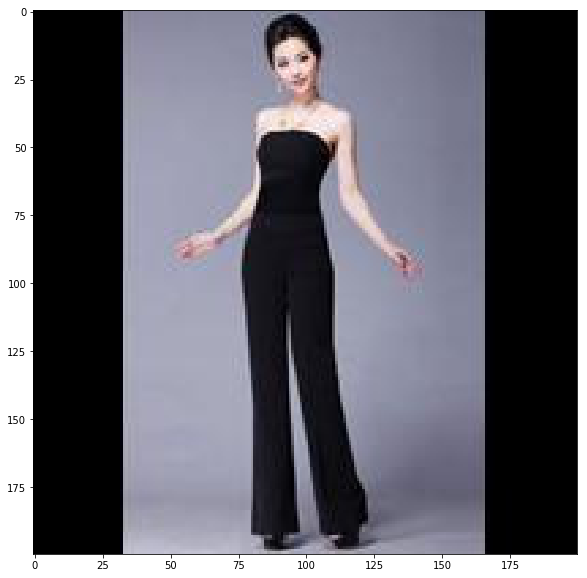

In [381]:
Image_Get(IndexNum)


In [184]:
Class_Prediction(IndexNum)

'Blouse'

In [346]:
Model_PredictionDF.iloc[IndexNum]

y_trueN                                                      Coat
y_true                                                         18
y_pred1                                                        18
Name1                                                        Coat
Name2                                                       Parka
Name3                                                      Jacket
Class1                                                         18
Class2                                                          8
Class3                                                          6
y_pred_prob     [0.00160306, 0.0284342, 8.63838e-06, 0.007603,...
x_files         Cat18/Two-Tone_Boucl&eacute;_Coat+img_00000009...
Prob_Class_1                                                39.40
Prob_Class_2                                                38.59
Prob_Class_3                                                 7.81
Name: 3688, dtype: object


#### Image Address


In [379]:
Model_PredictionDF.iloc[IndexNum][-4]


'Cat20/Woven_Ruffle_Cami_Jumpsuit+img_00000013.jpg'



### For any Image, feed in Index No. and get Top3 Predicted Categories and Probailites Respectively

In [24]:
def Get_Top3_Predictions(index):
    print('Top3 Predictions & Probabilities:')
    print('\n',Model_PredictionDF.iloc[index][3],'\n',Model_PredictionDF.iloc[index][11],'%')
    print('\n',Model_PredictionDF.iloc[index][4],'\n',Model_PredictionDF.iloc[index][12],'%')
    print('\n',Model_PredictionDF.iloc[index][5],'\n',Model_PredictionDF.iloc[index][13],'%')

In [25]:
Get_Top3_Predictions(IndexNum)

Top3 Predictions & Probabilities:

 Skirt 
 53.95 %

 Shorts 
 33.98 %

 Romper 
 4.13 %


### Plotting an Image given Index no. in Model_PredictionDF -- Both App & Pandas format

In [29]:
def Image_Get(index):
    pathA = '/home/ubuntu/data/Categories_22/Model_Train_Val_set/Test_Set/'
    ImageName = validation_generator.filenames[index].split('/')[1]
    pathCategory = validation_generator.filenames[index].split('/')[0]
    pathFull= pathA  +pathCategory+'/'+ImageName
    pathApp= '/home/ubuntu/data/Categories_22/App_Test_Img'
    image = Image.open((pathFull ))
    image.save(pathApp+'/'+ImageName)
    Each_Image_Matrix = array(Image.open(pathApp+'/'+ImageName))
    Each_Image_Matrix=Each_Image_Matrix.reshape(1,200,200,3)
    plt.figure(figsize=(20,10))
    plt.imshow(Each_Image_Matrix[0])
    
    

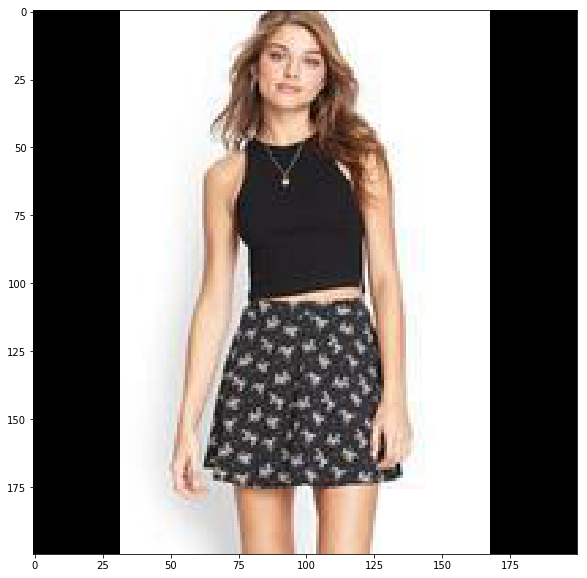

In [30]:
Image_Get(IndexNum)

In [31]:
def Class_Prediction(index):
    pathA = '/home/ubuntu/data/Categories_22/Model_Train_Val_set/Test_Set/'
    ImageName = validation_generator.filenames[index].split('/')[1]
    pathCategory = validation_generator.filenames[index].split('/')[0]
    pathFull= pathA  +pathCategory+'/'+ImageName
    pathApp= '/home/ubuntu/data/Categories_22/App_Test_Img'
    image = Image.open((pathFull ))
    image.save(pathApp+'/'+ImageName)
    Each_Image_Matrix = array(Image.open(pathApp+'/'+ImageName))
    Each_Image_Matrix=Each_Image_Matrix.reshape(1,200,200,3)
    Single_predictions_class=model_big.predict(Each_Image_Matrix/255)
    y_pred = np.argmax(Single_predictions_class, axis=1)
    Dict_id_cat={0: 'Blouse',1: 'Blazer',2: 'Tank',3: 'Sweater',4: 'Hoodie',5: 'Cardigan',6: 'Jacket',7: 'Poncho',
                 8: 'Parka', 9: 'Skirt', 10: 'Shorts', 11: 'Jeans', 12: 'Joggers', 13: 'Cutoffs', 14: 'Leggings',
                 15: 'Culottes', 16: 'Dress', 17: 'Romper', 18: 'Coat', 19: 'Kimono', 20: 'Jumpsuit', 21: 'Tee'}
    return Dict_id_cat[y_pred[0]]
 
 
 
 

In [32]:
Class_Prediction(IndexNum)

'Skirt'

## Run the following lines of codes as alternative to the functions above

#### Print image given index

In [62]:
pathA = '/home/ubuntu/data/Categories_22/Model_Train_Val_set/Test_Set/'

In [63]:
validation_generator.filenames[2855]

'Cat14/Tropical_Floral_Leggings+img_00000012.jpg'

In [64]:
ImageName = validation_generator.filenames[2863].split('/')[1]
pathCategory = validation_generator.filenames[2863].split('/')[0]

In [65]:
pathFull= pathA  +pathCategory+'/'+ImageName 

In [66]:
pathFull 

'/home/ubuntu/data/Categories_22/Model_Train_Val_set/Test_Set/Cat14/Tropical_Print_Leggings+img_00000027.jpg'

In [67]:
pathApp= '/home/ubuntu/data/Categories_22/App_Test_Img'

In [68]:
%%time

image = Image.open((pathFull ))


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 413 µs


In [69]:
image.save(pathApp+'/'+ImageName)

In [70]:
Each_Image_Matrix = array(Image.open(pathApp+'/'+ImageName))

In [72]:
Each_Image_Matrix=Each_Image_Matrix.reshape(1,200,200,3)

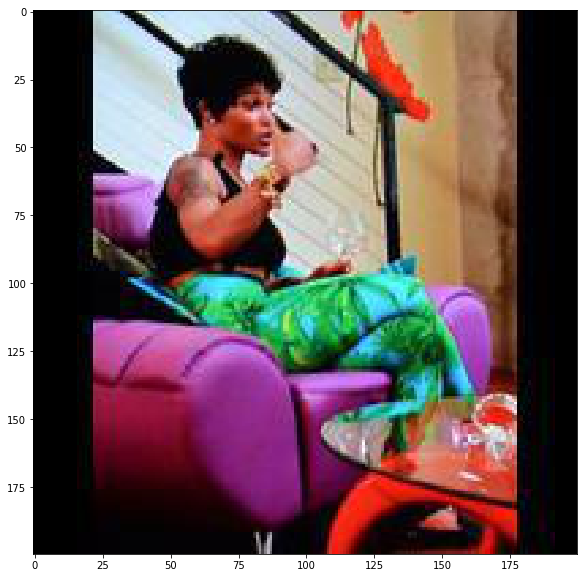

In [75]:
plt.figure(figsize=(20,10))
plt.imshow(Each_Image_Matrix[0])


Predicting Top Class

In [109]:
Single_predictions_class=model_big.predict(Each_Image_Matrix/255)
Single_predictions_class

array([[ 0.056301  ,  0.0517166 ,  0.03556792,  0.05486637,  0.04068704,
         0.04938997,  0.05908983,  0.03176117,  0.02919267,  0.06190021,
         0.05665861,  0.05253184,  0.042552  ,  0.06062285,  0.03549257,
         0.04907432,  0.03990922,  0.02996283,  0.04949815,  0.03149237,
         0.03212551,  0.04960693]], dtype=float32)

In [116]:
y_pred = np.argmax(Single_predictions_class, axis=1)

In [117]:
y_pred[0]

9

In [118]:
Dict_id_cat={0: 'Blouse',
 1: 'Blazer',
 2: 'Tank',
 3: 'Sweater',
 4: 'Hoodie',
 5: 'Cardigan',
 6: 'Jacket',
 7: 'Poncho',
 8: 'Parka',
 9: 'Skirt',
 10: 'Shorts',
 11: 'Jeans',
 12: 'Joggers',
 13: 'Cutoffs',
 14: 'Leggings',
 15: 'Culottes',
 16: 'Dress',
 17: 'Romper',
 18: 'Coat',
 19: 'Kimono',
 20: 'Jumpsuit',
 21: 'Tee'}

In [119]:
Dict_id_cat[y_pred[0]]

'Skirt'

In [132]:
Single_predictions_class[0]

array([ 0.056301  ,  0.0517166 ,  0.03556792,  0.05486637,  0.04068704,
        0.04938997,  0.05908983,  0.03176117,  0.02919267,  0.06190021,
        0.05665861,  0.05253184,  0.042552  ,  0.06062285,  0.03549257,
        0.04907432,  0.03990922,  0.02996283,  0.04949815,  0.03149237,
        0.03212551,  0.04960693], dtype=float32)

In [133]:
index = (Single_predictions_class[0].argsort())[-3:][::-1]
index

array([ 9, 13,  6])

In [150]:
print('Top3 Predictions','\tProbabilities')
print(Dict_id_cat[index[0]],'\t\t\t',"%.2f" %(Single_predictions_class[0][index[0]]*100),'%')
print(Dict_id_cat[index[1]],'\t\t',"%.2f" %(Single_predictions_class[0][index[1]]*100),'%')
print(Dict_id_cat[index[2]],'\t\t\t',"%.2f" %(Single_predictions_class[0][index[2]]*100),'%')

Top3 Predictions 	Probabilities
Skirt 			 6.19 %
Cutoffs 		 6.06 %
Jacket 			 5.91 %


In [152]:
0.056301  +  0.0517166 +  0.03556792+   0.05486637+   0.04068704+ \
        0.04938997+  0.05908983+ 0.03176117+ 0.02919267+   0.06190021+\
        0.05665861+  0.0525318+ 0.042552  +  0.06062285+ 0.03549257+\
        0.04907432+ 0.03990922+  0.02996283+  0.04949815+  0.03149237+\
        0.03212551+0.04960693

0.99999994

### Incase of  Shifting of y_true labels 

In [122]:
y_new_true =[]
for i in range(len(y_true)):
    if y_true[i] >=9:
        y_new_true.append(y_true[i] - 9)
    else:
        y_new_true.append(y_true[i] + 21-8)
    

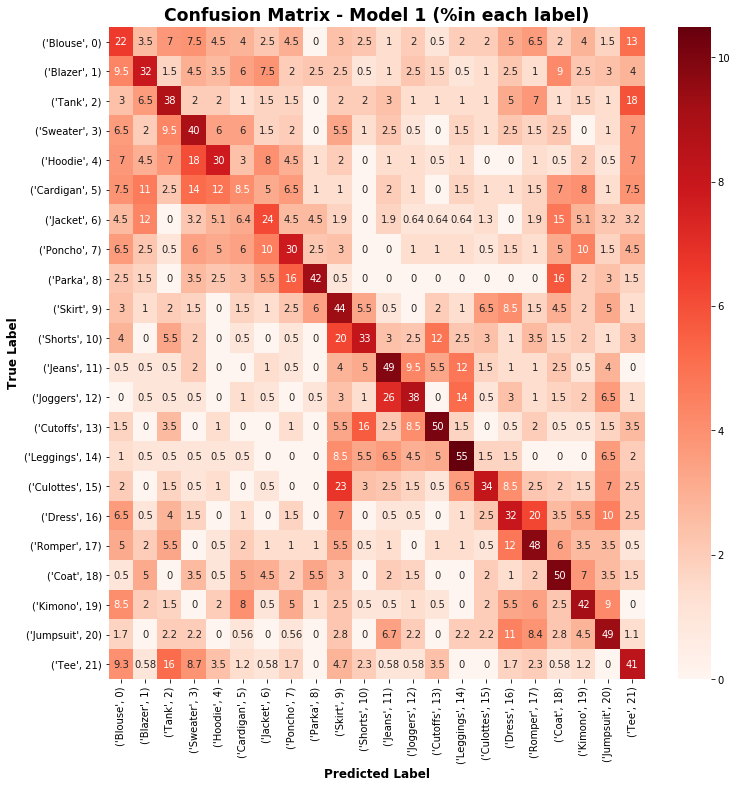

In [123]:
#### Confusion Matrix

from sklearn.metrics import classification_report,confusion_matrix

figsize(12, 12)
plot_confusion('Confusion Matrix - Model 1 (%in each label)',y_new_true,y_pred)# Adding 1 to y_pred as our labels/catgories start from1

In [124]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy: %.3f"% accuracy_score(y_new_true, y_pred))
print(classification_report(y_new_true, y_pred))

Accuracy: 0.378
             precision    recall  f1-score   support

          0       0.20      0.21      0.21       200
          1       0.37      0.32      0.34       200
          2       0.36      0.39      0.37       200
          3       0.33      0.40      0.36       200
          4       0.38      0.30      0.34       200
          5       0.13      0.09      0.10       200
          6       0.27      0.24      0.26       156
          7       0.35      0.30      0.33       200
          8       0.63      0.42      0.51       200
          9       0.29      0.43      0.34       200
         10       0.42      0.33      0.37       200
         11       0.44      0.49      0.46       200
         12       0.48      0.38      0.42       200
         13       0.59      0.51      0.55       200
         14       0.53      0.55      0.54       200
         15       0.53      0.34      0.41       200
         16       0.31      0.32      0.32       200
         17       0.41      0

In [245]:
model_big.predict( Each_Image_Matrix, batch_size=1, verbose=0)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]], dtype=float32)